# Embeddings in Transformers: A Comprehensive Guide

This notebook provides a thorough guide to embeddings in transformer models, implementing them from scratch while referencing the nanochat architecture. We'll cover token embeddings, positional embeddings (including rotary embeddings), and the unembedding layer.

## Table of Contents
1. [Introduction to Embeddings](#introduction)
2. [Token Embeddings](#token-embeddings)
3. [Positional Embeddings](#positional-embeddings)
4. [Rotary Position Embeddings](#rotary-embeddings)
5. [Combined Embeddings](#combined-embeddings)
6. [Unembedding Layer](#unembedding)
7. [Implementation from Scratch](#implementation)
8. [Visualization](#visualization)
9. [Training a Simple Model](#training)

## Introduction to Embeddings

Embeddings are the foundation of transformer models. They convert discrete tokens (words, subwords, or characters) into continuous vector representations that capture semantic meaning and relationships.

In the nanochat architecture (a minimal LLM training codebase), embeddings serve three main purposes:
1. **Token Embeddings (wte)**: Map tokens to dense vectors
2. **Positional Embeddings**: Add position information to tokens
3. **Unembedding (lm_head)**: Project back to vocabulary space for prediction

Key insights from nanochat:
- Token embeddings use `torch.nn.Embedding`
- Positional information uses rotary embeddings (RoPE)
- The unembedding layer is untied from token embeddings for better performance
- Learning rates are scaled by `(n_embd/768)^-0.5` for embeddings

## Setup and Imports

Let's start by importing the necessary libraries and setting up our environment.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Token Embeddings

Token embeddings map discrete tokens to continuous vector representations. In nanochat, this is implemented using `torch.nn.Embedding`.

The embedding layer learns a lookup table where each token ID maps to a dense vector of dimension `n_embd`.

In [2]:
# Define vocabulary size and embedding dimension
vocab_size = 1000  # Size of our vocabulary
n_embd = 128       # Embedding dimension (nanochat uses various sizes)

# Create token embedding layer (wte in nanochat)
token_embedding = nn.Embedding(vocab_size, n_embd)
token_embedding.to(device)

print(f"Token embedding shape: {token_embedding.weight.shape}")
print(f"Number of parameters: {token_embedding.weight.numel()}")

# Example: Convert token IDs to embeddings
token_ids = torch.tensor([[1, 5, 10, 25]], dtype=torch.long).to(device)
embedded_tokens = token_embedding(token_ids)

print(f"Input token IDs shape: {token_ids.shape}")
print(f"Embedded tokens shape: {embedded_tokens.shape}")
print(f"Sample embedding values:\n{embedded_tokens[0, :3, :5]}")  # First 3 tokens, first 5 dimensions

Token embedding shape: torch.Size([1000, 128])
Number of parameters: 128000
Input token IDs shape: torch.Size([1, 4])
Embedded tokens shape: torch.Size([1, 4, 128])
Sample embedding values:
tensor([[ 1.9312,  1.0119, -1.4364, -1.1299, -0.1360],
        [-1.2787, -0.0384,  1.9138,  0.3378,  0.1251],
        [-0.2949, -0.2799,  1.0837,  0.1730,  0.5124]], device='cuda:0',
       grad_fn=<SliceBackward0>)


## Positional Embeddings

Traditional positional embeddings add absolute position information. However, nanochat uses **Rotary Position Embeddings (RoPE)**, which encode relative positional relationships more effectively.

RoPE applies rotation matrices to the embedding vectors based on their positions, allowing the model to better capture relative distances between tokens.

## Rotary Position Embeddings (RoPE)

RoPE rotates embedding vectors based on their positions using precomputed cosine and sine values. This allows the attention mechanism to capture relative positional relationships.

The key insight: Instead of adding positional embeddings, we rotate the token embeddings using position-dependent rotation matrices.

In [11]:
def precompute_freqs_cis(dim: int, end: int, theta: float = 10000.0):
    """
    Precompute the frequency tensor for complex exponentials (cis) with cos and sin.
    This is used in rotary position embeddings.


    Args:
        dim: Dimension of the embedding
        end: Maximum sequence length
        theta: Base for the frequency calculation
    """
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
    t = torch.arange(end, device=freqs.device)
    freqs = torch.outer(t, freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
    return freqs_cis

def apply_rotary_emb(tensor: torch.Tensor, freqs_cis: torch.Tensor) -> torch.Tensor:
    """
    Apply rotary position embedding to the input tensor.


    Args:
        tensor: Input tensor of shape (batch_size, seq_len, n_heads, head_dim)
        freqs_cis: Precomputed frequencies of shape (seq_len, head_dim//2)
    """
    # Convert to complex
    x_complex = torch.view_as_complex(tensor.float().reshape(*tensor.shape[:-1], -1, 2))

    # Apply rotation
    # freqs_cis has shape (seq_len, dim); expand it to (1, seq_len, 1, dim)
    # so it broadcasts against x_complex which is (batch, seq_len, n_heads, dim)
    x_rotated = x_complex * freqs_cis.unsqueeze(0).unsqueeze(2)

    # Convert back to real
    x_out = torch.view_as_real(x_rotated).reshape(tensor.shape)
    return x_out.type_as(tensor)

# Example usage
max_seq_len = 100
freqs_cis = precompute_freqs_cis(n_embd, max_seq_len)  # For head_dim = n_embd // n_heads, but simplified

print(f"Frequency cis shape: {freqs_cis.shape}")
print(f"Sample frequency values: {freqs_cis[:3, :3]}")

Frequency cis shape: torch.Size([100, 64])
Sample frequency values: tensor([[ 1.0000+0.0000j,  1.0000+0.0000j,  1.0000+0.0000j],
        [ 0.5403+0.8415j,  0.6479+0.7617j,  0.7318+0.6816j],
        [-0.4161+0.9093j, -0.1604+0.9870j,  0.0709+0.9975j]])


## Combined Embeddings

In the full transformer architecture, token embeddings and positional embeddings are combined. In nanochat, this happens within the attention mechanism where RoPE is applied to the query and key vectors.

For simplicity, let's show how embeddings are combined before being fed into the transformer layers.

In [5]:
# Create a simple embedding layer that combines token and positional embeddings
class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, n_embd, max_seq_len=100):
        super().__init__()
        if n_embd % 2 != 0:
            raise ValueError("n_embd must be even for rotary embeddings.")
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.n_embd = n_embd
        self.max_seq_len = max_seq_len

        # Precompute rotary frequencies (freqs_cis has shape (max_seq_len, n_embd//2))
        self.register_buffer("freqs_cis", precompute_freqs_cis(n_embd, max_seq_len))

    def forward(self, token_ids):
        batch_size, seq_len = token_ids.shape

        if seq_len > self.max_seq_len:
            raise ValueError(f"Sequence length {seq_len} exceeds max_seq_len {self.max_seq_len}.")

        # Get token embeddings
        token_embeds = self.token_embedding(token_ids)  # (batch_size, seq_len, n_embd)

        # Apply rotary position embeddings (simplified: operate on interleaved pairs)
        # Reshape to (..., n_embd//2, 2) so we can view as complex numbers
        x = token_embeds.view(batch_size, seq_len, self.n_embd // 2, 2)
        x_complex = torch.view_as_complex(x)  # shape (batch_size, seq_len, n_embd//2), complex64/128

        # Select freqs for current sequence length: shape (seq_len, n_embd//2), complex
        freqs = self.freqs_cis[:seq_len]  # (seq_len, n_embd//2), complex tensor
        # Multiply: broadcast freqs over the batch dimension
        x_rotated = x_complex * freqs.unsqueeze(0)  # (batch_size, seq_len, n_embd//2)

        # Convert back to real and reshape to (batch_size, seq_len, n_embd)
        x_out = torch.view_as_real(x_rotated).reshape(batch_size, seq_len, self.n_embd)
        final_embeds = x_out.type_as(token_embeds)

        return final_embeds

# Test the combined embedding layer
embedding_layer = EmbeddingLayer(vocab_size, n_embd)
embedding_layer.to(device)

# Test with sample input
sample_input = torch.tensor([[1, 5, 10, 25, 100]], dtype=torch.long).to(device)
embedded_output = embedding_layer(sample_input)

print(f"Input shape: {sample_input.shape}")
print(f"Output shape: {embedded_output.shape}")
print(f"Sample embedded values:\n{embedded_output[0, :3, :5]}")

Input shape: torch.Size([1, 5])
Output shape: torch.Size([1, 5, 128])
Sample embedded values:
tensor([[ 1.0045, -0.2112, -0.1598,  0.7320,  1.0199],
        [-0.1661,  0.1361,  1.1595, -0.1797, -2.2410],
        [ 1.0905, -1.5149,  1.2894, -1.4849, -2.0955]], device='cuda:0',
       grad_fn=<SliceBackward0>)


## Unembedding Layer (lm_head)

The unembedding layer projects the final transformer outputs back to vocabulary space for next-token prediction. In nanochat, this is implemented as a separate linear layer (`lm_head`) that is **untied** from the token embeddings (`wte`).

Key points from nanochat:
- `lm_head` is `torch.nn.Linear(n_embd, vocab_size)`
- It's initialized with zeros (not random weights)
- It uses the same learning rate scaling as token embeddings: `(n_embd/768)^-0.5`

In [6]:
# Create unembedding layer (lm_head in nanochat)
lm_head = nn.Linear(n_embd, vocab_size, bias=False)
lm_head.to(device)

# Initialize weights to zeros as in nanochat
with torch.no_grad():
    lm_head.weight.fill_(0.0)

print(f"Unembedding layer shape: {lm_head.weight.shape}")
print(f"Number of parameters: {lm_head.weight.numel()}")

# Test unembedding
# Simulate transformer output (normally this would come from the transformer layers)
transformer_output = torch.randn(1, 5, n_embd).to(device)  # batch_size=1, seq_len=5

# Get logits for next token prediction
logits = lm_head(transformer_output)
print(f"Logits shape: {logits.shape}")  # Should be (batch_size, seq_len, vocab_size)

# Get predicted token IDs
predicted_tokens = torch.argmax(logits, dim=-1)
print(f"Predicted tokens: {predicted_tokens}")

# Get probabilities
probabilities = torch.softmax(logits, dim=-1)
print(f"Probabilities shape: {probabilities.shape}")
print(f"Sample probabilities for first position:\n{probabilities[0, 0, :10]}")  # First 10 vocab items

Unembedding layer shape: torch.Size([1000, 128])
Number of parameters: 128000
Logits shape: torch.Size([1, 5, 1000])
Predicted tokens: tensor([[0, 0, 0, 0, 0]], device='cuda:0')
Probabilities shape: torch.Size([1, 5, 1000])
Sample probabilities for first position:
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010], device='cuda:0', grad_fn=<SliceBackward0>)


## Complete Implementation from Scratch

Let's create a complete embedding system that mirrors nanochat's architecture, including proper initialization and optimizer setup.

In [12]:
class NanoChatEmbeddings(nn.Module):
    """
    Complete embedding system inspired by nanochat's architecture.
    Includes token embeddings (wte), rotary position embeddings, and unembedding (lm_head).
    """
    def __init__(self, vocab_size, n_embd, max_seq_len=1024):
        super().__init__()
        self.vocab_size = vocab_size
        self.n_embd = n_embd
        self.max_seq_len = max_seq_len

        # Token embeddings (wte)
        self.wte = nn.Embedding(vocab_size, n_embd)

        # Unembedding layer (lm_head) - untied from wte
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

        # Precompute rotary frequencies
        self.register_buffer("freqs_cis", precompute_freqs_cis(n_embd, max_seq_len))

        # Initialize lm_head weights to zeros (nanochat style)
        with torch.no_grad():
            self.lm_head.weight.fill_(0.0)

    def forward(self, token_ids, targets=None):
        """
        Forward pass through embeddings.

        Args:
            token_ids: Input token IDs (batch_size, seq_len)
            targets: Target token IDs for loss computation (optional)

        Returns:
            logits: Prediction logits (batch_size, seq_len, vocab_size)
            loss: Cross-entropy loss (if targets provided)
        """
        batch_size, seq_len = token_ids.shape

        # Get token embeddings
        token_embeds = self.wte(token_ids)  # (batch_size, seq_len, n_embd)

        # Apply rotary position embeddings (simplified - normally done in attention)
        freqs_cis = self.freqs_cis[:seq_len]

        # Reshape for rotary application
        token_embeds_reshaped = token_embeds.view(batch_size, seq_len, 1, n_embd)
        rotated_embeds = apply_rotary_emb(token_embeds_reshaped, freqs_cis)
        final_embeds = rotated_embeds.view(batch_size, seq_len, n_embd)

        # Get logits through unembedding layer
        logits = self.lm_head(final_embeds)

        # Compute loss if targets provided
        loss = None
        if targets is not None:
            loss = nn.functional.cross_entropy(
                logits.view(-1, self.vocab_size),
                targets.view(-1),
                ignore_index=-1
            )

        return logits, loss

    def get_learning_rate_scale(self):
        """
        Get learning rate scaling factor for embeddings (nanochat style).
        Scales by (n_embd/768)^-0.5
        """
        return (self.n_embd / 768.0) ** -0.5

# Test the complete implementation
model = NanoChatEmbeddings(vocab_size, n_embd)
model.to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Learning rate scale: {model.get_learning_rate_scale():.4f}")

# Test forward pass
test_input = torch.randint(0, vocab_size, (2, 10)).to(device)  # batch_size=2, seq_len=10
test_targets = torch.randint(0, vocab_size, (2, 10)).to(device)

logits, loss = model(test_input, test_targets)
print(f"Input shape: {test_input.shape}")
print(f"Logits shape: {logits.shape}")
print(f"Loss: {loss.item():.4f}")

Model parameters: 256,000
Learning rate scale: 2.4495
Input shape: torch.Size([2, 10])
Logits shape: torch.Size([2, 10, 1000])
Loss: 6.9078


## Visualization

Let's visualize the embeddings to understand how they capture semantic relationships. We'll use PCA and t-SNE to reduce the high-dimensional embeddings to 2D for visualization.

Embeddings shape for visualization: (50, 128)


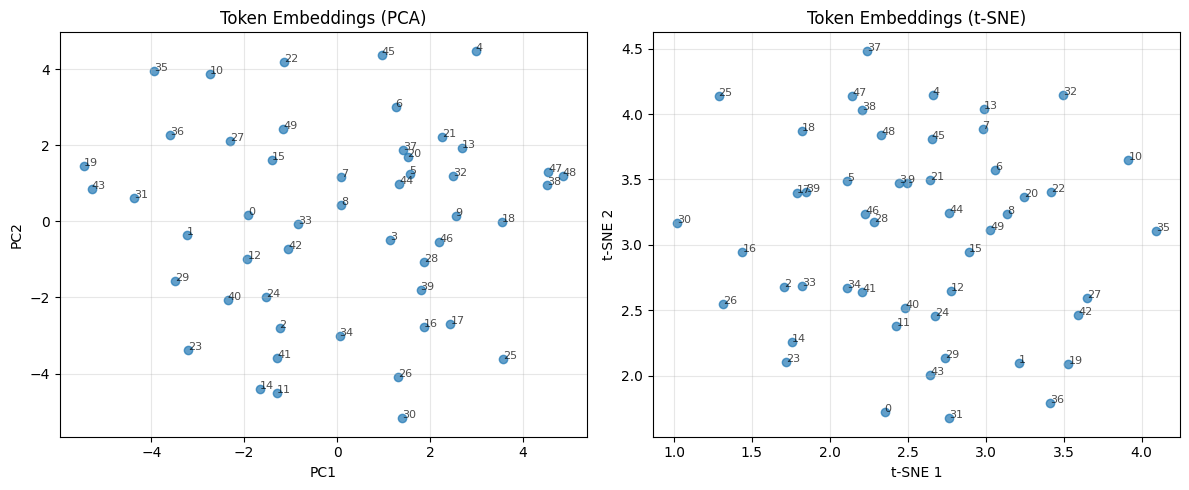

PCA explained variance: PC1=0.055, PC2=0.050
Total explained variance: 0.105


In [13]:
# Create some sample embeddings for visualization
sample_tokens = torch.arange(min(50, vocab_size)).to(device)  # First 50 tokens
embeddings = model.wte(sample_tokens).detach().cpu().numpy()

print(f"Embeddings shape for visualization: {embeddings.shape}")

# PCA visualization
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(12, 5))

# Plot PCA
plt.subplot(1, 2, 1)
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.7)
for i, (x, y) in enumerate(embeddings_pca):
    plt.annotate(str(i), (x, y), fontsize=8, alpha=0.7)
plt.title('Token Embeddings (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
embeddings_tsne = tsne.fit_transform(embeddings)

plt.subplot(1, 2, 2)
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.7)
for i, (x, y) in enumerate(embeddings_tsne):
    plt.annotate(str(i), (x, y), fontsize=8, alpha=0.7)
plt.title('Token Embeddings (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show explained variance for PCA
explained_variance = pca.explained_variance_ratio_
print(f"PCA explained variance: PC1={explained_variance[0]:.3f}, PC2={explained_variance[1]:.3f}")
print(f"Total explained variance: {explained_variance.sum():.3f}")

## Training a Simple Model

Let's train our embedding model on a simple next-token prediction task. We'll use the same optimizer setup as nanochat: AdamW for embeddings with learning rate scaling.

Base learning rate: 0.0004
Learning rate scale: 2.4495
Final learning rate: 0.000980
Training embeddings...
Training embeddings...
Batch 20/100, Loss: 6.9068
Batch 40/100, Loss: 6.9160
Batch 60/100, Loss: 6.9045
Batch 20/100, Loss: 6.9068
Batch 40/100, Loss: 6.9160
Batch 60/100, Loss: 6.9045
Batch 80/100, Loss: 6.9263
Batch 100/100, Loss: 6.8923
Batch 80/100, Loss: 6.9263
Batch 100/100, Loss: 6.8923


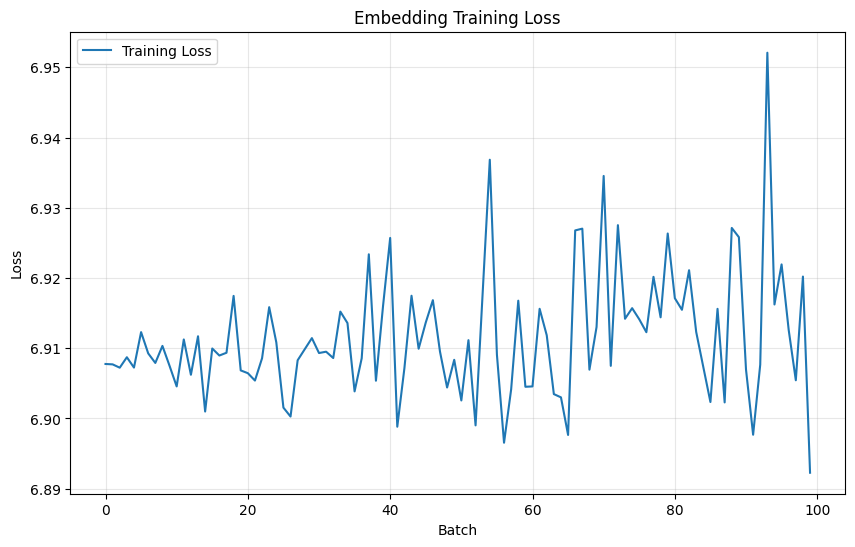

Final loss: 6.8923
Initial loss: 6.9078
Loss reduction: 0.2%


In [14]:
# Training setup
learning_rate_scale = model.get_learning_rate_scale()
base_lr = 0.0004  # Base learning rate from nanochat
learning_rate = base_lr * learning_rate_scale

print(f"Base learning rate: {base_lr}")
print(f"Learning rate scale: {learning_rate_scale:.4f}")
print(f"Final learning rate: {learning_rate:.6f}")

# Create optimizer (AdamW for embeddings as in nanochat)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Generate some training data (random for demonstration)
batch_size = 4
seq_len = 20
num_batches = 100

print("Training embeddings...")

losses = []
for batch_idx in range(num_batches):
    # Generate random batch
    input_tokens = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)
    target_tokens = torch.randint(0, vocab_size, (batch_size, seq_len)).to(device)

    # Forward pass
    logits, loss = model(input_tokens, target_tokens)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (batch_idx + 1) % 20 == 0:
        print(f"Batch {batch_idx+1}/{num_batches}, Loss: {loss.item():.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Embedding Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Loss reduction: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")

## Conclusion

In this notebook, we've implemented a complete embedding system inspired by nanochat's architecture:

### Key Components Implemented:
1. **Token Embeddings (wte)**: `nn.Embedding` layer mapping tokens to dense vectors
2. **Rotary Position Embeddings (RoPE)**: Position-dependent rotations for relative positional encoding
3. **Unembedding Layer (lm_head)**: Linear projection back to vocabulary space, untied from token embeddings
4. **Proper Initialization**: lm_head weights initialized to zeros
5. **Optimizer Setup**: AdamW with learning rate scaling `(n_embd/768)^-0.5`

### Key Insights from Nanochat:
- **Untied Embeddings**: lm_head is separate from wte for better performance
- **RoPE over Absolute PE**: Rotary embeddings capture relative relationships more effectively
- **Zero Initialization**: lm_head starts with zero weights
- **Scaled Learning Rates**: Embeddings use scaled learning rates based on embedding dimension

### Applications:
- **Language Modeling**: Next-token prediction
- **Text Classification**: Using [CLS] token embeddings
- **Semantic Search**: Finding similar texts in embedding space
- **Transfer Learning**: Fine-tuning pretrained embeddings

This foundation sets the stage for building complete transformer models, as explored in the subsequent notebooks in this series.